##Attack LSTM Model

###Description:
- In this Code, we implement LSTM model from attacker's perspective to successfully conduct a Website Fingerprinting(WF) attack
- Input: Preprocessed WFs
- Output: Reconstructed WFs

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from csv import writer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, Conv1D,MaxPooling1D,BatchNormalization
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split



import numpy as np
import pandas as pd

import matplotlib
from matplotlib import ticker as ticker
import matplotlib.pyplot as plt

import h5py
import os
from sklearn.metrics import f1_score


#os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import CuDNNLSTM, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Input : Preprocessed Website Fingerprint(WF) dataset

In [4]:
train_X = pd.read_csv('/content/drive/MyDrive/Data/trainX_2_US_Chrome.csv', header=None)
train_Y = pd.read_csv('/content/drive/MyDrive/Data/trainY_2_US_Chrome.csv', header=None)


In [5]:
trainX = train_X.to_numpy()
trainY = train_Y.to_numpy()

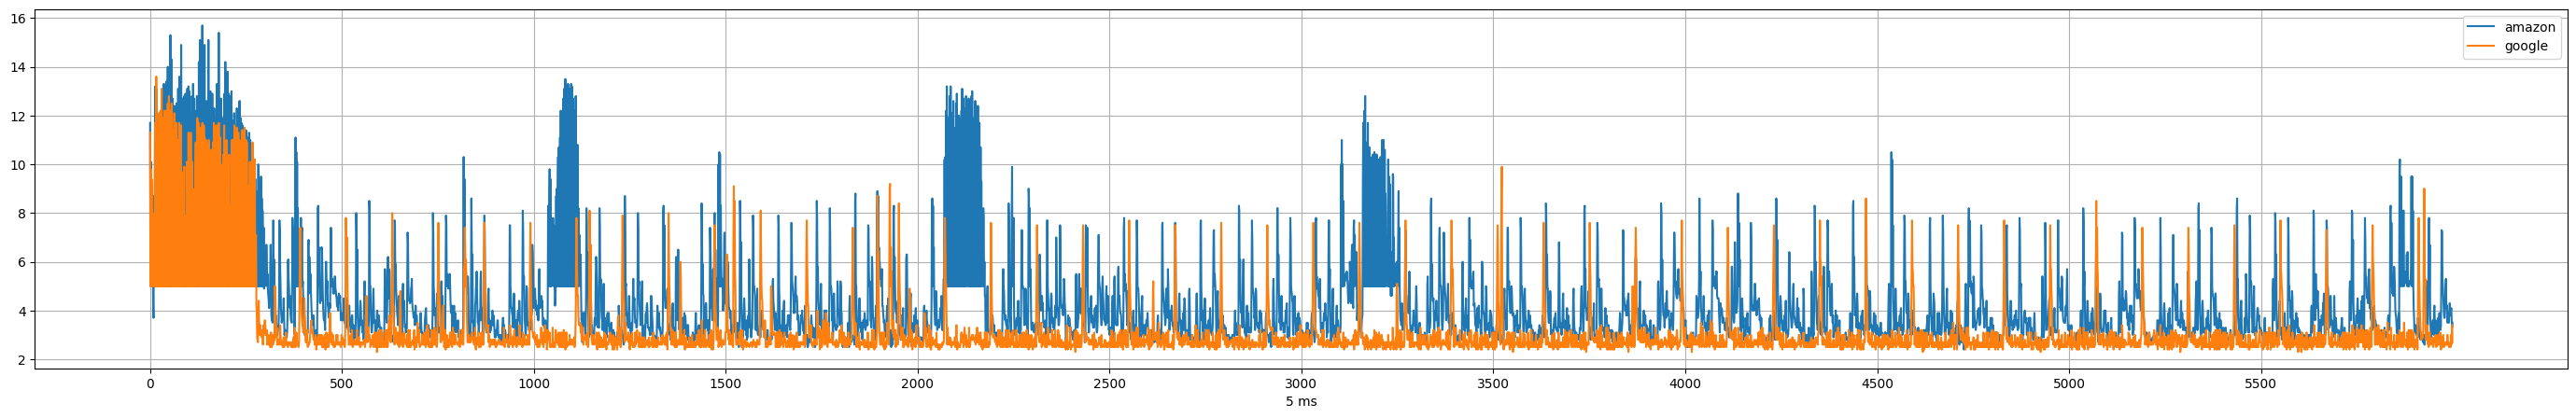

In [6]:
fig = plt.figure(figsize=(35,5))
plt.plot(trainX[0],label='amazon')
plt.plot(trainX[100],label='google')

plt.legend()
plt.xticks(np.arange(0, 6000, 500))
plt.grid()
plt.xlabel("5 ms")
#fig.savefig('Graph_Amaozon_Google.png')
plt.show()

In [7]:
trainX = np.expand_dims(trainX,axis=2)

In [8]:
print(trainX.shape)


(200, 6000, 1)


In [9]:
input_data = trainX

In [10]:

minimum = np.amin(input_data)
maximum = np.amax(input_data)

input_data_norm = (input_data-minimum)/(maximum-minimum)
#trainX_normalized = trainX

print(input_data_norm.shape)

input_data_norm = input_data_norm


(200, 6000, 1)


In [11]:
trainY= keras.utils.to_categorical(trainY)
print(trainY.shape)

(200, 2)


In [12]:
# set aside 20% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(input_data_norm, trainY ,test_size=0.2, shuffle = False, random_state = 8)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2

print("--------------Data--------------")
print("Orignal X shape: {}".format(input_data_norm.shape))
print("Origianl Y shape: {}".format(trainY.shape))
input_data_norm
print("--------------Train Data--------------")
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))

print("--------------Validation Data--------------")
print("X_val shape: {}".format(X_val.shape))
print("y val shape: {}".format(y_val.shape))

print("--------------Test Data--------------")
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))



--------------Data--------------
Orignal X shape: (200, 6000, 1)
Origianl Y shape: (200, 2)
--------------Train Data--------------
X_train shape: (120, 6000, 1)
y_train shape: (120, 2)
--------------Validation Data--------------
X_val shape: (40, 6000, 1)
y val shape: (40, 2)
--------------Test Data--------------
X_test shape: (40, 6000, 1)
y_test shape: (40, 2)


In [13]:
def model_create(x=None):
    numberOfWebsite=2

    input = keras.Input(shape = (6000,1))
    x = layers.LSTM(32,input_shape=(X_train.shape[1:]), return_sequences=True)(input)

    x = layers.Conv1D(256, 32, activation="relu", padding="same")(x)
    x = MaxPooling1D(pool_size=4)(x)


    x = layers.Conv1D(256, 32, activation="relu", padding="same")(x)
    x = MaxPooling1D(pool_size=4)(x)

    x = layers.Dropout(0.7)(x)

    x = layers.Flatten()(x)

    '''

    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    '''
    x = Dense(numberOfWebsite,activation='softmax')(x)

    model = keras.Model(inputs = input, outputs = x)

    return model




In [14]:
model = model_create()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6000, 1)]         0         
                                                                 
 lstm (LSTM)                 (None, 6000, 32)          4352      
                                                                 
 conv1d (Conv1D)             (None, 6000, 256)         262400    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1500, 256)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1500, 256)         2097408   
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 375, 256)         0         
 1D)                                                         

In [15]:
#import tensorflow as tf
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


In [16]:
#Compiling the network
model.compile( loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'] )


In [17]:
'''#Compiling the network
model.compile( loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001, decay=1e-6),
              metrics=['accuracy'] )

'''

"#Compiling the network\nmodel.compile( loss='categorical_crossentropy',\n              optimizer=Adam(learning_rate=0.001, decay=1e-6),\n              metrics=['accuracy'] )\n\n"

In [18]:
#Fitting the data to the model
print(X_train.shape)
history = model.fit(X_train,y_train,epochs=40,batch_size=100,validation_data=(X_val, y_val))

(120, 6000, 1)
Epoch 1/40
2/2 [==============================] - 28s 4s/step - loss: 44.6542 - accuracy: 0.5333 - val_loss: 159.5151 - val_accuracy: 0.4500
Epoch 2/40
2/2 [==============================] - 1s 414ms/step - loss: 114.6910 - accuracy: 0.5833 - val_loss: 250.9095 - val_accuracy: 0.5500
Epoch 3/40
2/2 [==============================] - 1s 403ms/step - loss: 236.9026 - accuracy: 0.5167 - val_loss: 114.1383 - val_accuracy: 0.5500
Epoch 4/40
2/2 [==============================] - 1s 322ms/step - loss: 99.2208 - accuracy: 0.5500 - val_loss: 3.1559 - val_accuracy: 0.2000
Epoch 5/40
2/2 [==============================] - 1s 361ms/step - loss: 2.5532 - accuracy: 0.3833 - val_loss: 0.3058 - val_accuracy: 0.8250
Epoch 6/40
2/2 [==============================] - 1s 310ms/step - loss: 0.3008 - accuracy: 0.8417 - val_loss: 1.1707 - val_accuracy: 0.8000
Epoch 7/40
2/2 [==============================] - 1s 318ms/step - loss: 1.1952 - accuracy: 0.7083 - val_loss: 0.0159 - val_accuracy: 1.

In [19]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
ac_lstm=score[1]

Test loss: 2.145758060123626e-07
Test accuracy: 1.0


In [20]:
model.optimizer.get_config()

{'name': 'Adam',
 'weight_decay': None,
 'clipnorm': None,
 'global_clipnorm': None,
 'clipvalue': None,
 'use_ema': False,
 'ema_momentum': 0.99,
 'ema_overwrite_frequency': None,
 'jit_compile': True,
 'is_legacy_optimizer': False,
 'learning_rate': {'class_name': 'ExponentialDecay',
  'config': {'initial_learning_rate': 0.01,
   'decay_steps': 10000,
   'decay_rate': 0.9,
   'staircase': False,
   'name': None}},
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

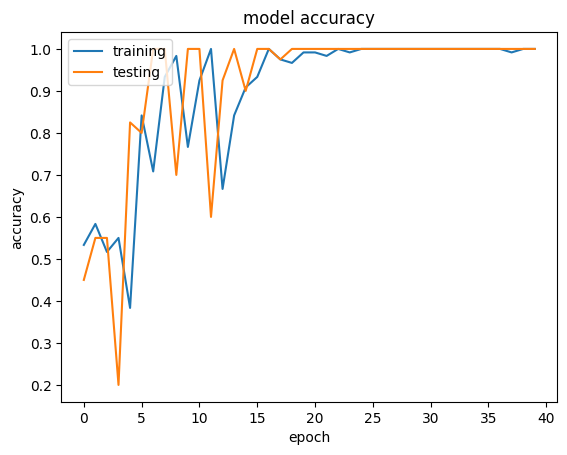

In [21]:
#plotting
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training','testing'], loc='upper left')
#fig.savefig('plotAcc_2.png')


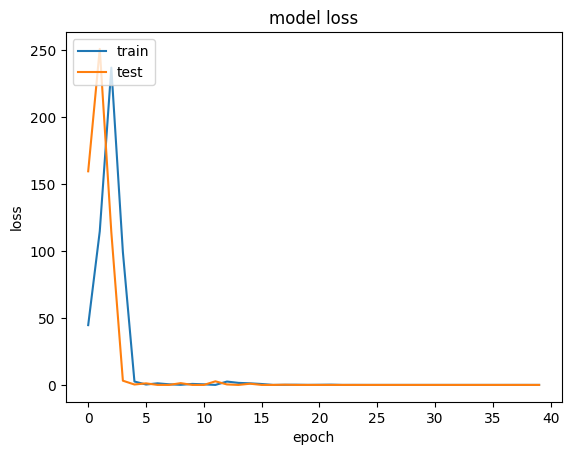

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','test'],loc='upper left')
plt.show()

# Pre-trained Model Save

In [23]:
model.save('LSTM_Pretrained_Model_chrome_W2.h5')